In [2]:
# plotting libraries
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# data analysis libraries
import pandas as pd
import numpy as np

# general imports
from pathlib import Path

# auxiliary functions
import s3ts.analysis as aux

In [4]:
df = aux.load_data(Path("results_synced/ratio/"))
#df.groupby(["dataset", "arch", "nsamp_tra", "nsamp_pre"]).count()
#df = df[df["fold_number"] == 1]
#df[df["pretrained"]]["target_best_model"].str.split("/").str[6].str.removeprefix("epoch=").str.split("-").str[0].astype(int).hist()
df

,dataset,arch,pretrained,fold_number,random_state,batch_size,window_size,target_val_acc,target_val_f1,target_val_auroc,...,target_nepochs,nsamp_tra,nsamp_pre,nsamp_test,pretrain_val_acc,pretrain_val_f1,pretrain_val_auroc,pretrain_best_model,pretrain_train_csv,pretrain_nepochs
0,GunPoint,ResNet_TS,False,4,0,128,5,0.518229,0.518229,0.503552,...,120,1227,0,5985,NaN,NaN,NaN,NaN,NaN,NaN
1,GunPoint,ResNet_TS,True,4,0,128,5,0.502604,0.502604,0.369496,...,120,1227,3627,5985,0.960069,0.960069,0.990953,training/exp/EXP_ratio_f4.0_2023-03-08_07-17/l...,training/exp/EXP_ratio_f4.0_2023-03-08_07-17/l...,60.0
2,GunPoint,ResNet_TS,True,4,0,128,5,0.497396,0.497396,0.538775,...,120,1227,7254,5985,0.959704,0.959704,0.993323,training/exp/EXP_ratio_f4.0_2023-03-08_07-23/l...,training/exp/EXP_ratio_f4.0_2023-03-08_07-23/l...,60.0
3,GunPoint,ResNet_TS,True,4,0,128,5,0.494792,0.494792,0.375771,...,120,1227,10881,5985,0.965681,0.965681,0.994463,training/exp/EXP_ratio_f4.0_2023-03-08_07-30/l...,training/exp/EXP_ratio_f4.0_2023-03-08_07-30/l...,60.0
4,GunPoint,ResNet_TS,True,4,0,128,5,0.528646,0.528646,0.687410,...,120,1227,14508,5985,0.957031,0.957031,0.994946,training/exp/EXP_ratio_f4.0_2023-03-08_07-38/l...,training/exp/EXP_ratio_f4.0_2023-03-08_07-38/l...,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,GunPoint,ResNet_TS,True,3,0,128,5,0.559082,0.559082,0.519742,...,120,6135,3627,5985,0.891493,0.891493,0.963834,training/exp/EXP_ratio_f3.4_2023-03-08_06-17/l...,training/exp/EXP_ratio_f3.4_2023-03-08_06-17/l...,60.0
1099,GunPoint,ResNet_TS,True,3,0,128,5,0.541016,0.541016,0.512700,...,120,6135,7254,5985,0.904605,0.904605,0.982224,training/exp/EXP_ratio_f3.4_2023-03-08_06-26/l...,training/exp/EXP_ratio_f3.4_2023-03-08_06-26/l...,60.0
1100,GunPoint,ResNet_TS,True,3,0,128,5,0.520020,0.520020,0.500444,...,120,6135,10881,5985,0.937779,0.937779,0.990147,training/exp/EXP_ratio_f3.4_2023-03-08_06-36/l...,training/exp/EXP_ratio_f3.4_2023-03-08_06-36/l...,60.0
1101,GunPoint,ResNet_TS,True,3,0,128,5,0.576172,0.576172,0.579706,...,120,6135,14508,5985,0.941406,0.941406,0.990062,training/exp/EXP_ratio_f3.4_2023-03-08_06-47/l...,training/exp/EXP_ratio_f3.4_2023-03-08_06-47/l...,60.0


In [5]:
dfr = aux.EXP_ratio_preprocessing(df)
dfr

,arch,dataset,nsamp_pre,nsamp_tra,pretrain_val_acc_mean,pretrain_val_acc_std,pretrain_val_auroc_mean,pretrain_val_auroc_std,pretrain_val_f1_mean,pretrain_val_f1_std,...,target_test_auroc_mean,target_test_auroc_std,target_test_f1_mean,target_test_f1_std,target_val_acc_mean,target_val_acc_std,target_val_auroc_mean,target_val_auroc_std,target_val_f1_mean,target_val_f1_std
0,CNN_DFS,Coffee,0,683,NaN,NaN,NaN,NaN,NaN,NaN,...,0.399082,0.021400,0.437988,0.011739,0.312500,0.000000,0.000000,0.000000,0.312500,0.000000
1,CNN_DFS,Coffee,1998,683,0.812500,0.017678,0.943704,0.021259,0.812500,0.017678,...,0.476540,0.042504,0.512370,0.039591,0.800781,0.016573,0.773828,0.023553,0.800781,0.016573
2,CNN_DFS,Coffee,3997,683,0.847266,0.019335,0.937462,0.023213,0.847266,0.019335,...,0.477514,0.006953,0.508777,0.011987,0.765625,0.093913,0.752095,0.080805,0.765625,0.093913
3,CNN_DFS,Coffee,5996,683,0.868896,0.007251,0.952854,0.000227,0.868896,0.007251,...,0.486374,0.031603,0.518417,0.037944,0.798828,0.002762,0.772195,0.079801,0.798828,0.002762
4,CNN_DFS,Coffee,7995,683,0.867001,0.004472,0.960240,0.003600,0.867001,0.004472,...,0.478362,0.031873,0.487442,0.014537,0.710938,0.049718,0.773580,0.025412,0.710938,0.049718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,ResNet_TS,PowerCons,0,6298,NaN,NaN,NaN,NaN,NaN,NaN,...,0.627511,NaN,0.629297,NaN,0.668457,NaN,0.666156,NaN,0.668457,NaN
281,ResNet_TS,PowerCons,6246,6298,0.756348,NaN,0.919529,NaN,0.756348,NaN,...,0.700194,NaN,0.637988,NaN,0.696289,NaN,0.753294,NaN,0.696289,NaN
282,ResNet_TS,PowerCons,12492,6298,0.811035,NaN,0.942490,NaN,0.811035,NaN,...,0.645328,NaN,0.635059,NaN,0.696289,NaN,0.687335,NaN,0.696289,NaN
283,ResNet_TS,PowerCons,18739,6298,0.797034,NaN,0.923224,NaN,0.797034,NaN,...,0.699925,NaN,0.627051,NaN,0.687500,NaN,0.759661,NaN,0.687500,NaN


In [26]:
dfr["dataset"].unique()

array(['Coffee', 'GunPoint', 'PowerCons'], dtype=object)

<Figure size 640x480 with 0 Axes>

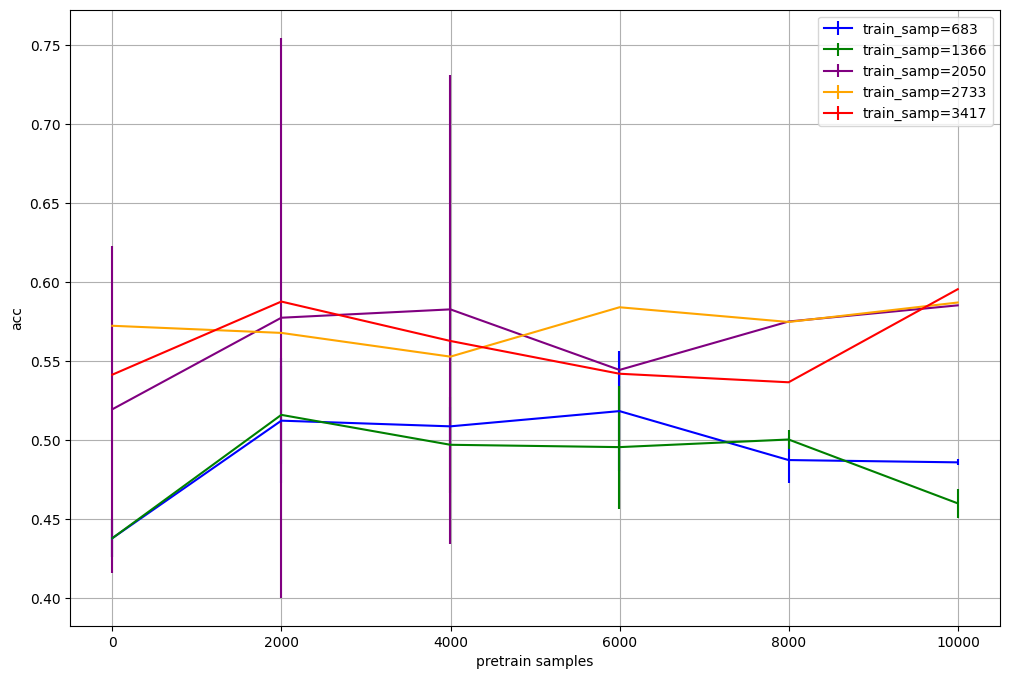

In [32]:

plt.figure()

metric = "acc"
arch = "CNN_DFS"
dataset = "Coffee"

colors = ["blue", "green", "purple", "orange", "red"]
fig, ax = plt.subplots(figsize=[12,8])
for i, (nsamp_pre, dfg) in enumerate(dfr[dfr["arch"] == arch][dfr["dataset"] == dataset].replace(np.NaN, 0).groupby("nsamp_tra")):
    # ax.plot(dfg["nsamp_pre"], dfg[f"target_test_{metric}_mean"], label=f'train_samp={dfg["nsamp_tra"].unique()[0]}', c=colors[i])
    ax.errorbar(dfg["nsamp_pre"], dfg[f"target_test_{metric}_mean"], yerr=dfg[f"target_test_{metric}_std"], 
                label=f'train_samp={dfg["nsamp_tra"].unique()[0]}', c=colors[i])
    # ax.fill_between(dfg["nsamp_pre"], y1=dfg[f"target_test_{metric}_mean"]+dfg[f"target_test_{metric}_std"], 
    #  y2=dfg[f"target_test_{metric}_mean"]-dfg[f"target_test_{metric}_std"], alpha = 0.5, color=colors[i])
plt.legend()
plt.grid(True)
plt.xlabel("pretrain samples")
plt.ylabel(metric);
plt.show();

In [39]:
dfrb = aux.EXP_ratio_set_baselines(dfr)
# dfrb[dfrb["nsamp_tra"]!=4908]["target_test_acc_mean"].max()
dfrb

,arch,dataset,nsamp_pre,nsamp_tra,target_test_acc_mean,target_test_acc_std,target_test_auroc_mean,target_test_auroc_std,target_test_f1_mean,target_test_f1_std,target_val_acc_mean,target_val_acc_std,target_val_auroc_mean,target_val_auroc_std,target_val_f1_mean,target_val_f1_std
0,CNN_DFS,Coffee,1998,683,0.074382,0.05133,0.077458,0.063903,0.074382,0.05133,0.488281,0.016573,0.773828,0.023553,0.488281,0.016573
1,CNN_DFS,Coffee,3997,683,0.070788,0.023726,0.078432,0.028353,0.070788,0.023726,0.453125,0.093913,0.752095,0.080805,0.453125,0.093913
2,CNN_DFS,Coffee,5996,683,0.080429,0.049683,0.087292,0.053002,0.080429,0.049683,0.486328,0.002762,0.772195,0.079801,0.486328,0.002762
3,CNN_DFS,Coffee,7995,683,0.049454,0.026276,0.07928,0.053272,0.049454,0.026276,0.398438,0.049718,0.77358,0.025412,0.398438,0.049718
4,CNN_DFS,Coffee,9995,683,0.048002,0.013598,0.085886,0.027375,0.048002,0.013598,0.357422,0.019335,0.745241,0.027923,0.357422,0.019335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,ResNet_TS,PowerCons,31233,4198,-0.025098,NaN,0.049341,NaN,-0.025098,NaN,-0.017756,NaN,0.074445,NaN,-0.017756,NaN
233,ResNet_TS,PowerCons,6246,6298,0.008691,NaN,0.072683,NaN,0.008691,NaN,0.027832,NaN,0.087139,NaN,0.027832,NaN
234,ResNet_TS,PowerCons,12492,6298,0.005762,NaN,0.017817,NaN,0.005762,NaN,0.027832,NaN,0.02118,NaN,0.027832,NaN
235,ResNet_TS,PowerCons,18739,6298,-0.002246,NaN,0.072414,NaN,-0.002246,NaN,0.019043,NaN,0.093505,NaN,0.019043,NaN


general improvement: 0.03968298733234406


nsamp_pre
1998    0.050428
3997    0.038987
5996    0.035059
7995    0.033013
9995    0.040928
Name: target_test_acc_mean, dtype: float64

<Figure size 640x480 with 0 Axes>

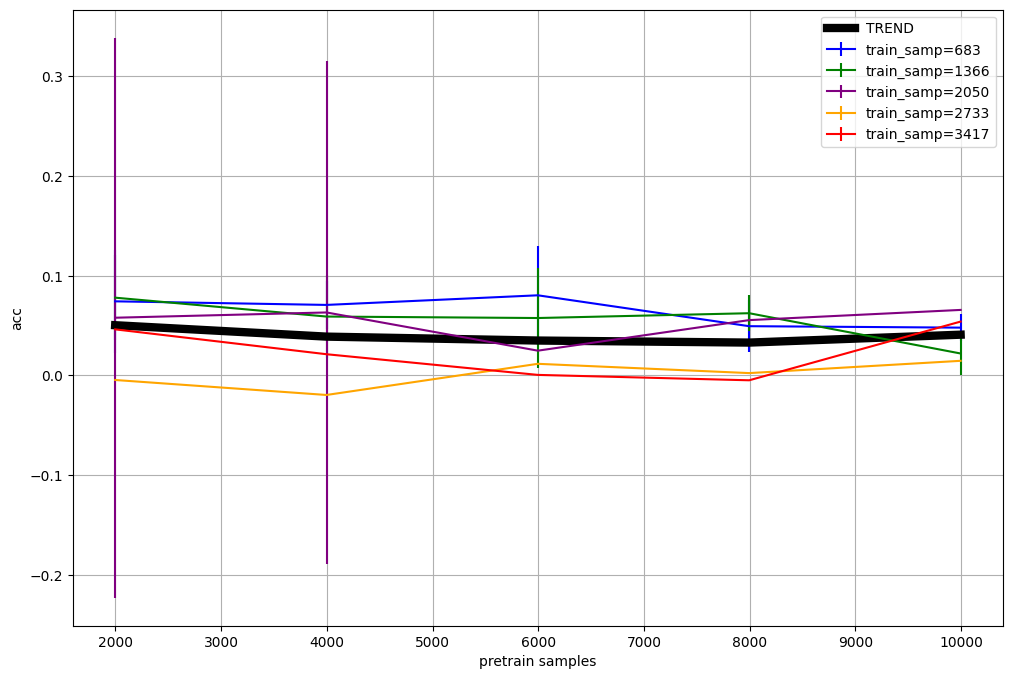

In [55]:

plt.figure()

#dfrb = dfrb[dfrb["nsamp_tra"] != 4908]

metric = "acc"
arch = "CNN_DFS"
dataset = "Coffee"

dfrb_filt = dfrb[dfrb["arch"] == arch][dfrb["dataset"] == dataset].replace(np.NaN, 0)


colors = ["blue", "green", "purple", "orange", "red"]
fig, ax = plt.subplots(figsize=[12,8])
for i, (nsamp_pre, dfg) in enumerate(dfrb_filt.groupby("nsamp_tra")):
    # ax.plot(dfg["nsamp_pre"], dfg[f"target_test_{metric}_mean"], label=f'train_samp={dfg["nsamp_tra"].unique()[0]}', c=colors[i])
    ax.errorbar(dfg["nsamp_pre"], dfg[f"target_test_{metric}_mean"], yerr=dfg[f"target_test_{metric}_std"], 
                label=f'train_samp={dfg["nsamp_tra"].unique()[0]}', c=colors[i])
    # ax.fill_between(dfg["nsamp_pre"], y1=dfg[f"target_test_{metric}_mean"]+dfg[f"target_test_{metric}_std"], 
    #  y2=dfg[f"target_test_{metric}_mean"]-dfg[f"target_test_{metric}_std"], alpha = 0.5, color=colors[i])

ax.plot(dfrb_filt["nsamp_pre"].unique(), dfrb_filt.groupby("nsamp_pre")[f"target_test_{metric}_mean"].mean(), label="TREND", c="black", lw=6)
plt.legend()
plt.grid(True)
plt.xlabel("pretrain samples")
plt.ylabel(metric)

print("general improvement:", dfrb_filt[f"target_test_{metric}_mean"].mean())
dfrb_filt.groupby("nsamp_pre")[f"target_test_{metric}_mean"].mean()



In [58]:
df = aux.load_data(Path("results_synced/quantiles/"))
df

,dataset,arch,pretrained,fold_number,random_state,batch_size,window_size,target_val_acc,target_val_f1,target_val_auroc,...,nsamp_tra,nsamp_pre,nsamp_test,pretrain_nquant,pretrain_val_acc,pretrain_val_f1,pretrain_val_auroc,pretrain_best_model,pretrain_train_csv,pretrain_nepochs
0,GunPoint,CNN_DFS,False,0,0,128,5,0.768066,0.768066,0.831575,...,6135,0,5985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GunPoint,CNN_DFS,True,0,0,128,5,0.771973,0.771973,0.836356,...,6135,18135,5985,3.0,0.911735,0.911735,0.984602,training/exp/EXP_quant_f0.0_2023-03-08_11-21/l...,training/exp/EXP_quant_f0.0_2023-03-08_11-21/l...,60.0
2,GunPoint,CNN_DFS,True,0,0,128,5,0.771484,0.771484,0.828854,...,6135,18135,5985,5.0,0.884309,0.884309,0.977935,training/exp/EXP_quant_f0.1_2023-03-08_11-27/l...,training/exp/EXP_quant_f0.1_2023-03-08_11-27/l...,60.0
3,GunPoint,CNN_DFS,True,0,0,128,5,0.694336,0.694336,0.767606,...,6135,18135,5985,7.0,0.816988,0.816988,0.967523,training/exp/EXP_quant_f0.2_2023-03-08_11-33/l...,training/exp/EXP_quant_f0.2_2023-03-08_11-33/l...,60.0
4,GunPoint,CNN_DFS,True,0,0,128,5,0.753906,0.753906,0.810815,...,6135,18135,5985,9.0,0.782580,0.782580,0.972851,training/exp/EXP_quant_f0.3_2023-03-08_11-40/l...,training/exp/EXP_quant_f0.3_2023-03-08_11-40/l...,60.0
5,GunPoint,CNN_DFS,False,3,0,128,5,0.603516,0.603516,0.676341,...,6135,0,5985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GunPoint,CNN_DFS,True,3,0,128,5,0.595215,0.595215,0.652723,...,6135,18135,5985,3.0,0.909574,0.909574,0.976117,training/exp/EXP_quant_f3.0_2023-03-08_12-47/l...,training/exp/EXP_quant_f3.0_2023-03-08_12-47/l...,60.0
7,GunPoint,CNN_DFS,True,3,0,128,5,0.589355,0.589355,0.657601,...,6135,18135,5985,5.0,0.850066,0.850066,0.966855,training/exp/EXP_quant_f3.1_2023-03-08_12-53/l...,training/exp/EXP_quant_f3.1_2023-03-08_12-53/l...,60.0
8,GunPoint,CNN_DFS,True,3,0,128,5,0.705566,0.705566,0.740593,...,6135,18135,5985,7.0,0.814328,0.814328,0.963814,training/exp/EXP_quant_f3.2_2023-03-08_13-00/l...,training/exp/EXP_quant_f3.2_2023-03-08_13-00/l...,60.0
9,GunPoint,CNN_DFS,True,3,0,128,5,0.628906,0.628906,0.605455,...,6135,18135,5985,9.0,0.725565,0.725565,0.957279,training/exp/EXP_quant_f3.3_2023-03-08_13-06/l...,training/exp/EXP_quant_f3.3_2023-03-08_13-06/l...,60.0


<AxesSubplot: xlabel='pretrain_nquant', ylabel='target_test_acc'>

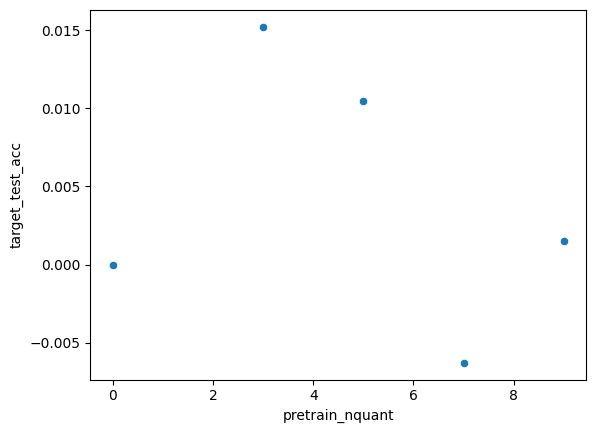

In [78]:
metric = "acc"
arch = "CNN_DFS"
dataset = "GunPoint"

data = df[df["dataset"] == dataset][df["arch"] == arch].replace(np.NaN, 0).groupby(["arch", "dataset", "pretrain_nquant"])[f"target_test_{metric}"].mean()

sns.scatterplot((data - data.iloc[0]).reset_index(), x="pretrain_nquant", y=f"target_test_{metric}")
